In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files
uploaded = files.upload()

Saving auto-mpg.csv to auto-mpg.csv


In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv("auto-mpg.csv", names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [16]:
!pip install pandas
import pandas as pd

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
              'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv("auto-mpg.csv", names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# Calculate statistics for normalization
train_stats = train_dataset.describe().transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [22]:
# Convert 'train_labels' to numeric type,
# but first handle potential errors by setting errors='coerce'
train_labels = pd.to_numeric(train_labels, errors='coerce')

# Check for any NaN values introduced due to conversion errors
# This will help identify the problematic rows
nan_indices = train_labels.isna()

# Print the rows with NaN values in 'train_labels' to investigate further
print(train_dataset[nan_indices])

# Now, fit the model
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])




    Cylinders Displacement Horsepower Weight Acceleration  Model Year  USA  \
132   corolla         1200        NaN    NaN          NaN         NaN  0.0   
309   phoenix          NaN        NaN    NaN          NaN         NaN  0.0   
334    280-zx          NaN        NaN    NaN          NaN         NaN  0.0   
196  chevette          NaN        NaN    NaN          NaN         NaN  0.0   
246    fiesta          NaN        NaN    NaN          NaN         NaN  0.0   
..        ...          ...        ...    ...          ...         ...  ...   
207     pinto          NaN        NaN    NaN          NaN         NaN  0.0   
279  scirocco          NaN        NaN    NaN          NaN         NaN  0.0   
227   skylark          NaN        NaN    NaN          NaN         NaN  0.0   
148       128          NaN        NaN    NaN          NaN         NaN  0.0   
143    dasher          NaN        NaN    NaN          NaN         NaN  0.0   

     Europe  Japan  
132     0.0    0.0  
309     0.0    0.0  


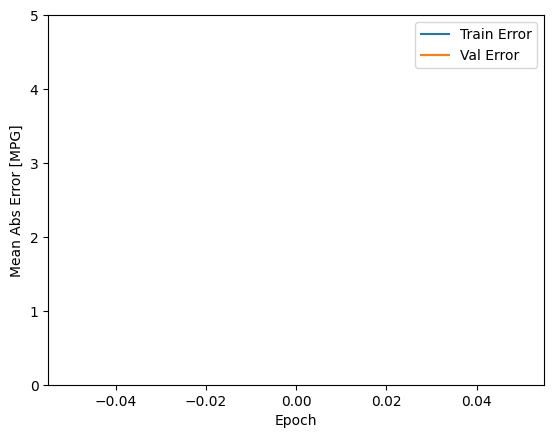

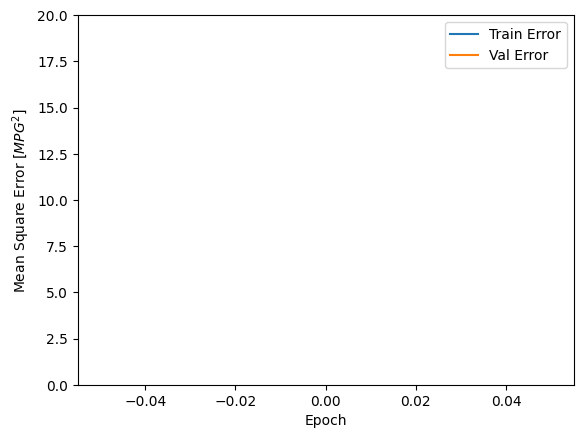

In [23]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
plot_history(history)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



..........

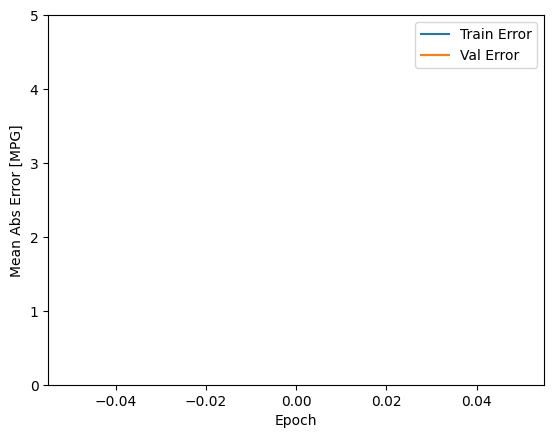

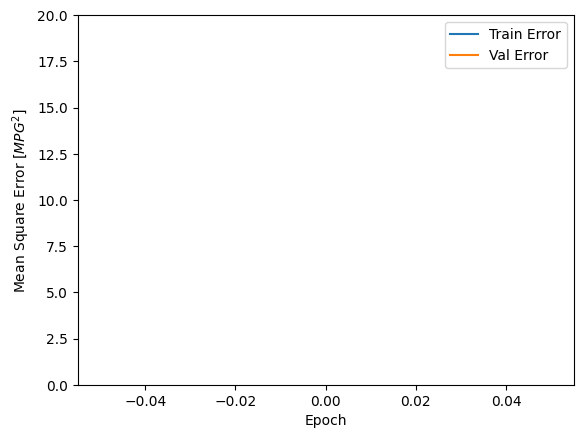

In [24]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [26]:
# Convert 'test_labels' to numeric type.
test_labels = pd.to_numeric(test_labels, errors='coerce')

# Check for any NaN values introduced due to conversion errors
nan_indices = test_labels.isna()

# Print the rows with NaN values in 'test_labels' to investigate further
print(test_dataset[nan_indices])

# Now evaluate the model
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

    Cylinders Displacement Horsepower Weight Acceleration  Model Year  USA  \
9    catalina          NaN        NaN    NaN          NaN         NaN  0.0   
25    gremlin          NaN        NaN    NaN          NaN         NaN  0.0   
28       d200          NaN        NaN    NaN          NaN         NaN  0.0   
31       vega         2300        NaN    NaN          NaN         NaN  0.0   
32     corona          NaN        NaN    NaN          NaN         NaN  0.0   
..        ...          ...        ...    ...          ...         ...  ...   
369  cavalier        wagon        NaN    NaN          NaN         NaN  0.0   
371     j2000           se  hatchback    NaN          NaN         NaN  0.0   
383   corolla          NaN        NaN    NaN          NaN         NaN  0.0   
385     civic       (auto)        NaN    NaN          NaN         NaN  0.0   
397    ranger          NaN        NaN    NaN          NaN         NaN  0.0   

     Europe  Japan  
9       0.0    0.0  
25      0.0    0.0  


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


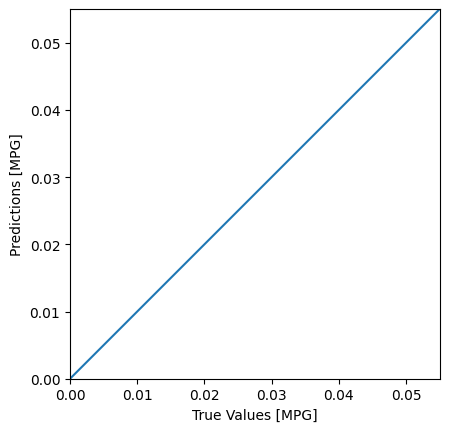

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

